In [2]:
from basic_utils import *
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

from copy import deepcopy as copy
import cooler

In [4]:
experiment_ids = "A9 B15 B19 B26 B3 B31 sc19 sc29 A2 A3 A5 A6 A8 B16 B6 sc1 sc16 sc21 sc23 sc24".split()
labels = copy(experiment_ids)
colors = 'RED     MAGENTA BROWN   ORANGE  GREEN   DARKGRAY        DARKBLUE        LIGHTBLUE       LIGHTGRAY'.split()
chrms = ['chr2L', 'chr3L', 'chr2R', 'chr3R', 'chrX']
resolution = 10

## Models colors

In [5]:
# Writing chromatin colors for models colouring

df_colors = pd.read_csv("/home/agalicina/GENOMES/DM3_ANNOT/COLORS/9STATE_BG3_10K.binned", sep='\t')
df_colors.columns = "Chr     Bin     RED     MAGENTA BROWN   ORANGE  GREEN   DARKGRAY        DARKBLUE        LIGHTBLUE       LIGHTGRAY".split()
df_colors.loc[:, "bin"] = df_colors.Bin//10000

df_colors.loc[:, 'ch'] = df_colors.Chr


selected = 0.5

df_colors.loc[:,'polycomb'] = df_colors.apply(lambda x: x.DARKGRAY>selected, axis=1)
df_colors.loc[:,'inactive'] = df_colors.apply(lambda x: x.LIGHTGRAY>selected, axis=1)
df_colors.loc[:,'active']   = df_colors.apply(lambda x: x.RED+x.MAGENTA>selected, axis=1)

df_colors.loc[:, 'state'] = df_colors.apply(
    lambda x: 'active' if x.active else 'inactive' if x.inactive else 'polycomb' if x.polycomb else 'neutral', axis=1)

for ch in chrms:
    df_colors.loc[:,['ch', 'bin', 'state']].query("ch=='{}'".format(ch))\
    .to_csv("../DATA/ANNOT/colors_bybin_{}.tsv".format(ch), index=False, sep='\t')

In [7]:
df_colors = pd.read_csv("../DATA/TMP/TADs_annotated.csv")

selected = 0.5

df_colors.loc[:,'polycomb'] = df_colors.apply(lambda x: x.DARKGRAY>selected, axis=1)
df_colors.loc[:,'inactive'] = df_colors.apply(lambda x: x.LIGHTGRAY>selected, axis=1)
df_colors.loc[:,'active']   = df_colors.apply(lambda x: x.RED+x.MAGENTA>selected, axis=1)

df_colors.loc[:, 'state'] = df_colors.apply(
    lambda x: 'active' if x.active else 'inactive' if x.inactive else 'polycomb' if x.polycomb else 'neutral', axis=1)

chr_sizes = pd.read_csv("../DATA/GENOME/chrom.sizes_t", sep='\t', header=None)
chr_sizes.columns = ['ch', 'len']
chr_sizes.loc[:, 'bin_len'] = chr_sizes.len/resolution//1000



df_colors1 = pd.DataFrame(columns=['ch', 'bin', 'state', 'ntad'])

for ch in chrms:
    df_colors_tmp = df_colors.query('ch=="{}"'.format(ch)).reset_index(drop=True)
    j_prev = 0
    for i, r in df_colors_tmp.iterrows():
        
        for j in np.arange(j_prev, r.bgn, 1):
            df_colors1 = df_colors1.append({'ch':r.ch, 'bin':j, 'state':'neutral', 'ntad':'.'}, ignore_index=True)
            
        for j in np.arange(r.bgn, r.end, 1):
            df_colors1 = df_colors1.append({'ch':r.ch, 'bin':j, 'state':r.state, 'ntad':i}, ignore_index=True)
            
        j_prev = r.end
        
    for j in np.arange(j_prev, chr_sizes.query('ch=="{}"'.format(ch)).loc[:,'bin_len'].values[0], 1):
        df_colors1 = df_colors1.append({'ch':r.ch, 'bin':int(j), 'state':'neutral', 'ntad':'.'}, ignore_index=True)

for ch in chrms:
    df_colors1.loc[:,['ch', 'bin', 'state', 'ntad']].query("ch=='{}'".format(ch))\
    .to_csv("../DATA/ANNOT/colors_bytad_{}.tsv".format(ch), index=False, sep='\t')

## PyMol scripts 
In this section PyMol scripts are created. Note that they should be executed from PyMol environment. 

### Visualization of TADs

### FISH probes

### Radial distance calculation

In [ ]:
# in pymol: run /Users/agalicina/2018/MODELLING/pymol_distX_script.py

from pymol import cmd
import glob

cmd.do('''
bg_color white
set transparency, 0.8
set solvent_radius, 0.025
set surface_quality, 1
set surface_color, gray
set sphere_scale, 0.1
''')


outfile = "/Users/agalicina/2018/MODELLING/distX_info.txt"
with open(outfile, 'w') as outf:
        for file in glob.glob("/Users/agalicina/2018/MODELLING/chrx_mol2/*/*")+glob.glob("/Users/agalicina/2018/MODELLING/MODELS_SH/*/*"):
                cmd.do('''
                load {}, tmp
                set_bond stick_radius, 0.05, tmp
                hide everything, tmp
                show surface, tmp
                color gray40, tmp
                hide surface
                show sticks, tmp
                set stick_transparency, 0.8, (tmp)
                disable tmp
                pseudoatom com, (tmp)
                '''.format(file))

                for i in range(1, 2243):  # in total: 2242 at X chromosome

                        measurement = cmd.distance("(com)", "(idx {} and tmp)".format(i))
                        towrite = [i, measurement, file]
                        towrite = str("\t".join(["{}"]*len(towrite))+"\n").format(*towrite)
                        outf.write(towrite)

                cmd.do("delete all")

In [19]:
df1 = pd.read_csv("../DATA_MODEL/TMP/distX_info.txt", sep='\t', header=None)
df1.columns = ['idx', 'dist', 'file']
df1.loc[:, 'bin'] = df1.idx-1
df1.loc[:, 'ch'] = 'chrX'

df2 = pd.read_csv("../DATA/ANNOT/colors_bybin_chrX.tsv".format(ch), sep='\t')

df = pd.merge(df1, df2, on=['ch', 'bin'])

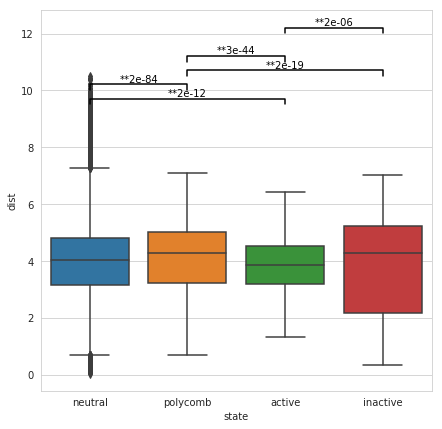

In [63]:
plt.figure(figsize=[7,7])
sns.boxplot( data=df, x="state", y="dist" ) 

for k1 in np.arange(4):
    for k2 in np.arange(k1+1, 4):
        label1 = plt.xticks()[1][k1].get_text()
        label2 = plt.xticks()[1][k2].get_text()
        
        v1, v2 = df.query("state=='{}'".format(label1))['dist'].values, df.query("state=='{}'".format(label2))['dist'].values
        pv = scipy.stats.mannwhitneyu(v1, v2).pvalue
        
        if pv>0.05:
            continue
        if pv>0.01:
            s = '*{:.0e}'.format(pv)
        else:
            s = '**{:.0e}'.format(pv)
        y, h = df['dist'].max() - 0.5*(k2-k1) + k1, 0.2
        plt.plot([k1, k1, k2, k2], [y, y+h, y+h, y], lw=1.5, c='k')
        plt.text((k1+k2)*0.5, y+h, s, ha='center', va='bottom', color='k')
        
    plt.savefig('../IMG/MODEL/Spatial_distance.pdf')